<a href="https://colab.research.google.com/github/Masoudvahid/4_in_1_bot/blob/main/xfeat_with_permutation_steerer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XFeat matching example using torch hub


## Initialize XFeat

In [ ]:
!gdown 1nzYg4dmkOAZPi4sjOGpQnawMoZSXYXHt  # Download xfeat weights for version trained with permutation steerer

Downloading...
From: https://drive.google.com/uc?id=1nzYg4dmkOAZPi4sjOGpQnawMoZSXYXHt
To: /content/xfeat_perm_steer.pth
100% 6.25M/6.25M [00:00<00:00, 29.6MB/s]


In [ ]:
import numpy as np
import imageio as imio
import os
import torch
import tqdm
import cv2
import matplotlib.pyplot as plt

xfeat = torch.hub.load('verlab/accelerated_features', 'XFeat', pretrained = False, top_k = 4096)
sd = torch.load('xfeat_perm_steer.pth', map_location='cpu')
for key in list(sd):
    sd['net.' + key] = sd[key]
    del sd[key]
xfeat.load_state_dict(sd)

#Load some example images
im1 = np.copy(imio.v2.imread('https://raw.githubusercontent.com/verlab/accelerated_features/main/assets/ref.png')[..., ::-1])
im2 = np.copy(imio.v2.imread('https://raw.githubusercontent.com/verlab/accelerated_features/main/assets/tgt.png')[..., ::-1])

Using cache found in /root/.cache/torch/hub/verlab_accelerated_features_main


In [ ]:
im1.shape

(600, 800, 3)

## Simple function that fits an homography in a set of matches and draw the homography transform

In [ ]:
# @title
import cv2
import numpy as np

def warp_corners_and_draw_matches(ref_points, dst_points, img1, img2):
    # Calculate the Homography matrix
    H, mask = cv2.findHomography(ref_points, dst_points, cv2.USAC_MAGSAC, 3.5, maxIters=1_000, confidence=0.999)
    mask = mask.flatten()

    # Get corners of the first image (image1)
    h, w = img1.shape[:2]
    corners_img1 = np.array([[0, 0], [w-1, 0], [w-1, h-1], [0, h-1]], dtype=np.float32).reshape(-1, 1, 2)

    # Warp corners to the second image (image2) space
    warped_corners = cv2.perspectiveTransform(corners_img1, H)

    # Draw the warped corners in image2
    img2_with_corners = img2.copy()
    for i in range(len(warped_corners)):
        start_point = tuple(warped_corners[i-1][0].astype(int))
        end_point = tuple(warped_corners[i][0].astype(int))
        cv2.line(img2_with_corners, start_point, end_point, (0, 255, 0), 4)  # Using solid green for corners

    # Prepare keypoints and matches for drawMatches function
    keypoints1 = [cv2.KeyPoint(p[0], p[1], 5) for p in ref_points]
    keypoints2 = [cv2.KeyPoint(p[0], p[1], 5) for p in dst_points]
    matches = [cv2.DMatch(i,i,0) for i in range(len(mask)) if mask[i]]

    # Draw inlier matches
    img_matches = cv2.drawMatches(img1, keypoints1, img2_with_corners, keypoints2, matches, None,
                                  matchColor=(0, 255, 0), flags=2)

    return img_matches

## Matching example - sparse setting

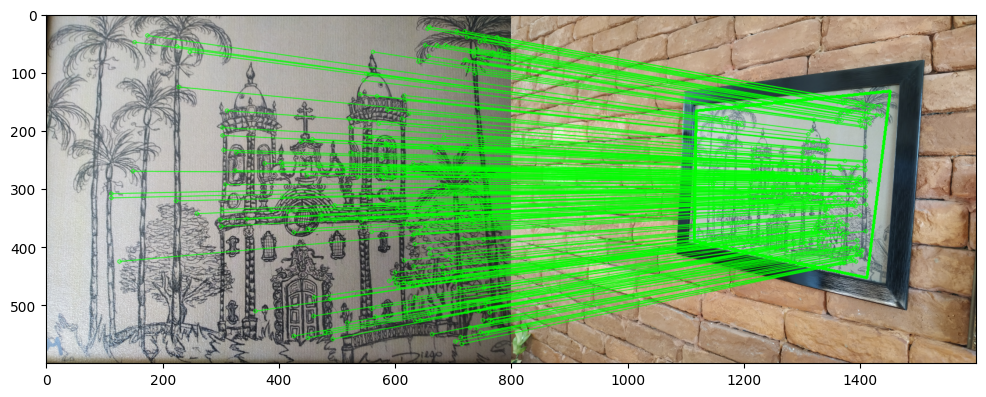

(<matplotlib.image.AxesImage at 0x7bd9c9e3bc10>, None)

In [ ]:
#Use out-of-the-box function for extraction + MNN matching
mkpts_0, mkpts_1 = xfeat.match_xfeat(im1, im2, top_k = 4096)

canvas = warp_corners_and_draw_matches(mkpts_0, mkpts_1, im1, im2)
plt.figure(figsize=(12,12))
plt.imshow(canvas[..., ::-1]), plt.show()

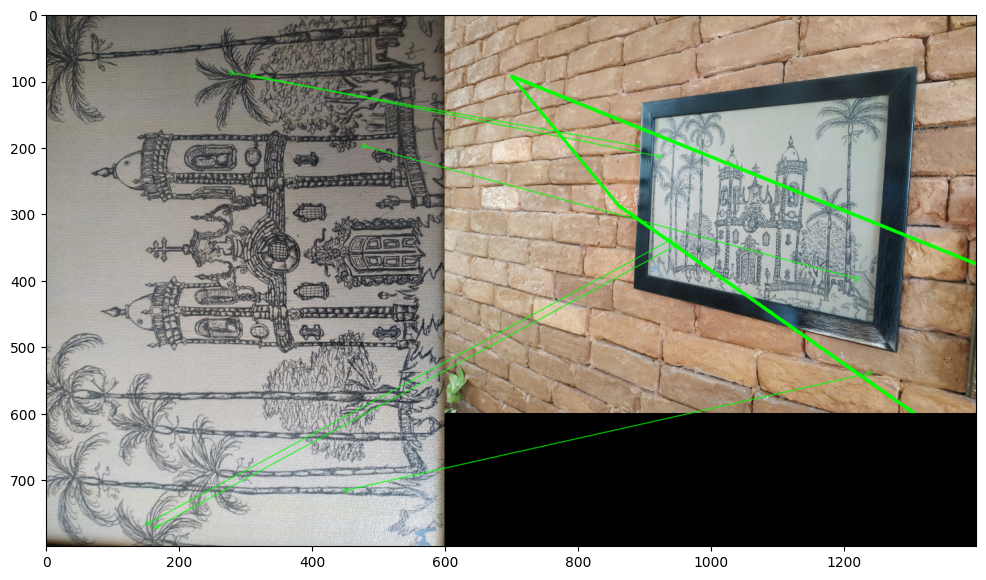

(<matplotlib.image.AxesImage at 0x7bd9cfd347c0>, None)

In [ ]:
# Can it match rotated images? No!
rot_im1 = np.rot90(im1, k=1, axes=(0, 1)).copy()
mkpts_0, mkpts_1 = xfeat.match_xfeat(rot_im1, im2, top_k = 4096)

canvas = warp_corners_and_draw_matches(mkpts_0, mkpts_1, rot_im1, im2)
plt.figure(figsize=(12,12))
plt.imshow(canvas[..., ::-1]), plt.show()

In [ ]:
# What if we use our secret steerer permutation? Let's slightly redefine the matching function to use the permutation!

STEER_PERMUTATIONS = [
    torch.arange(64).reshape(4, 16).roll(k, dims=0).reshape(64)
    for k in range(4)
]

@torch.inference_mode()
def match_xfeat_with_permutation_steerer(img1, img2, top_k = None, min_cossim = -1):
    """
        Simple extractor and MNN matcher.
        For simplicity it does not support batched mode due to possibly different number of kpts.
        input:
            img1 -> torch.Tensor (1,C,H,W) or np.ndarray (H,W,C): grayscale or rgb image.
            img2 -> torch.Tensor (1,C,H,W) or np.ndarray (H,W,C): grayscale or rgb image.
            top_k -> int: keep best k features
        returns:
            mkpts_0, mkpts_1 -> np.ndarray (N,2) xy coordinate matches from image1 to image2
    """
    if top_k is None: top_k = xfeat.top_k
    img1 = xfeat.parse_input(img1)
    img2 = xfeat.parse_input(img2)

    out1 = xfeat.detectAndCompute(img1, top_k=top_k)[0]
    out2 = xfeat.detectAndCompute(img2, top_k=top_k)[0]

    idxs0, idxs1 = xfeat.match(out1['descriptors'], out2['descriptors'], min_cossim=min_cossim)
    rot1to2 = 0
    for r in range(1, 4):
        new_idxs0, new_idxs1 = xfeat.match(out1['descriptors'][..., STEER_PERMUTATIONS[r]], out2['descriptors'], min_cossim=min_cossim)
        if len(new_idxs0) > len(idxs0):
            idxs0 = new_idxs0
            idxs1 = new_idxs1
            rot1to2 = r

    return out1['keypoints'][idxs0].cpu().numpy(), out2['keypoints'][idxs1].cpu().numpy(), rot1to2

Number 90 deg rotations from first image to second: 3


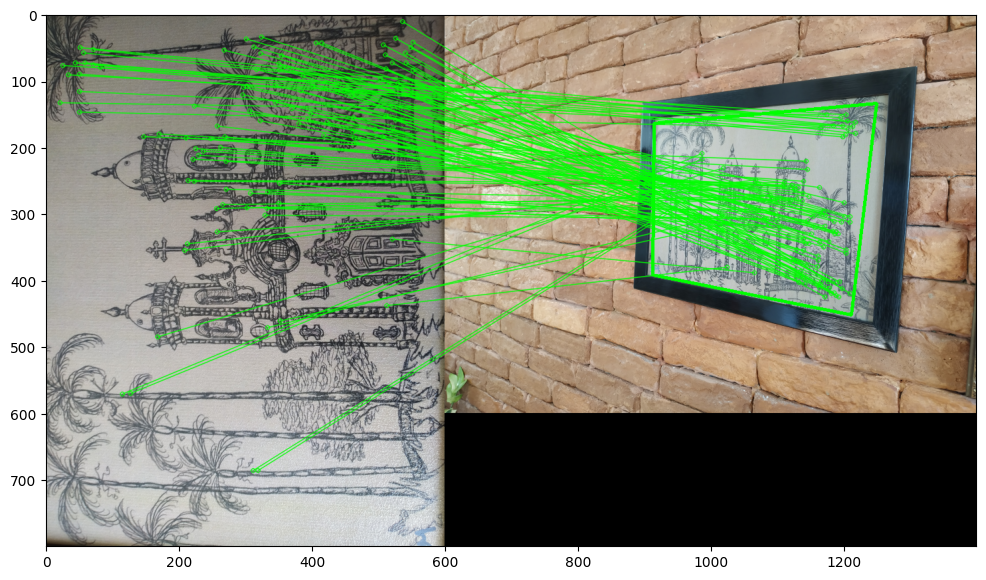

(<matplotlib.image.AxesImage at 0x7bd9c9c92140>, None)

In [ ]:
# Now it works! (But crucially depends on the threshold on min cossim.)
mkpts_0, mkpts_1, rot1to2 = match_xfeat_with_permutation_steerer(rot_im1, im2, top_k = 4096, min_cossim=.9)

print(f"Number 90 deg rotations from first image to second: {rot1to2}")

canvas = warp_corners_and_draw_matches(mkpts_0, mkpts_1, rot_im1, im2)
plt.figure(figsize=(12,12))
plt.imshow(canvas[..., ::-1]), plt.show()

## Matching example - Semi-dense setting

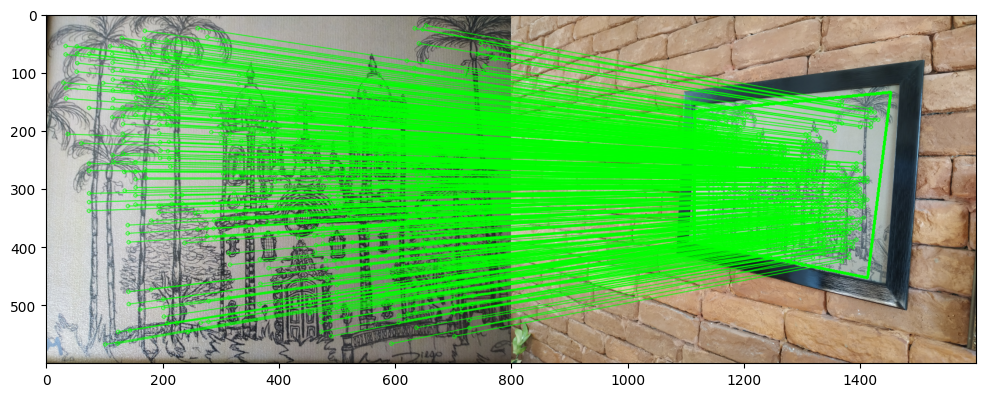

(<matplotlib.image.AxesImage at 0x7bd9c9d5a950>, None)

In [ ]:
#Use out-of-the-box function for extraction + coarse-to-fine matching
mkpts_0, mkpts_1 = xfeat.match_xfeat_star(im1, im2, top_k = 8000)

canvas = warp_corners_and_draw_matches(mkpts_0, mkpts_1, im1, im2)
plt.figure(figsize=(12,12))
plt.imshow(canvas[..., ::-1]), plt.show()

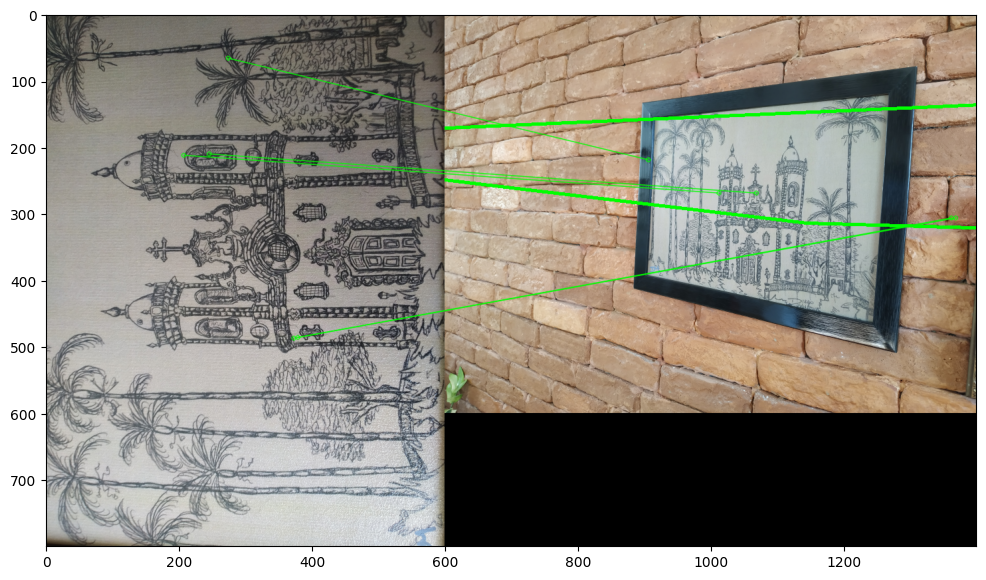

(<matplotlib.image.AxesImage at 0x7bd9cc15cc10>, None)

In [ ]:
# Can it match rotated images? No!
rot_im1 = np.rot90(im1, k=1, axes=(0, 1)).copy()
mkpts_0, mkpts_1 = xfeat.match_xfeat_star(rot_im1, im2, top_k = 8000)

canvas = warp_corners_and_draw_matches(mkpts_0, mkpts_1, rot_im1, im2)
plt.figure(figsize=(12,12))
plt.imshow(canvas[..., ::-1]), plt.show()

In [ ]:
# What if we use our secret steerer permutation? Let's slightly redefine the matching function to use the permutation!

STEER_PERMUTATIONS = [
    torch.arange(64).reshape(4, 16).roll(k, dims=0).reshape(64)
    for k in range(4)
]

@torch.inference_mode()
def match_xfeat_star_with_permutation_steerer(im_set1, im_set2, top_k = None, min_cossim_coarse=-1):
    """
        Extracts coarse feats, then match pairs and finally refine matches, currently supports batched mode.
        input:
            im_set1 -> torch.Tensor(B, C, H, W) or np.ndarray (H,W,C): grayscale or rgb images.
            im_set2 -> torch.Tensor(B, C, H, W) or np.ndarray (H,W,C): grayscale or rgb images.
            top_k -> int: keep best k features
        returns:
            matches -> List[torch.Tensor(N, 4)]: List of size B containing tensor of pairwise matches (x1,y1,x2,y2)
    """
    if top_k is None: top_k = xfeat.top_k

    B = im_set1.shape[0] if len(im_set1.shape) == 4 else 1
    if B > 1:
        raise NotImplementedError("TODO: Batched dense matching with steerer")

    im_set1 = xfeat.parse_input(im_set1)
    im_set2 = xfeat.parse_input(im_set2)

    #Compute coarse feats
    out1 = xfeat.detectAndComputeDense(im_set1, top_k=top_k)
    out2 = xfeat.detectAndComputeDense(im_set2, top_k=top_k)

    rot1to2 = 0
    idxs_list = xfeat.batch_match(out1['descriptors'], out2['descriptors'], min_cossim=min_cossim_coarse)
    for r in range(1, 4):
        new_idxs_list = xfeat.batch_match(out1['descriptors'][..., STEER_PERMUTATIONS[r]], out2['descriptors'], min_cossim=min_cossim_coarse)
        if len(new_idxs_list[0][0]) > len(idxs_list[0][0]):
            idxs_list = new_idxs_list
            rot1to2 = r

    out2['descriptors'] = out2['descriptors'][..., STEER_PERMUTATIONS[-rot1to2]]  # align to first image for refinement MLP

    #Refine coarse matches
    #this part is harder to batch, currently iterate
    matches = xfeat.refine_matches(out1, out2, matches=idxs_list, batch_idx=0)

    return matches[:, :2].cpu().numpy(), matches[:, 2:].cpu().numpy(), rot1to2

Number 90 deg rotations from first image to second: 3


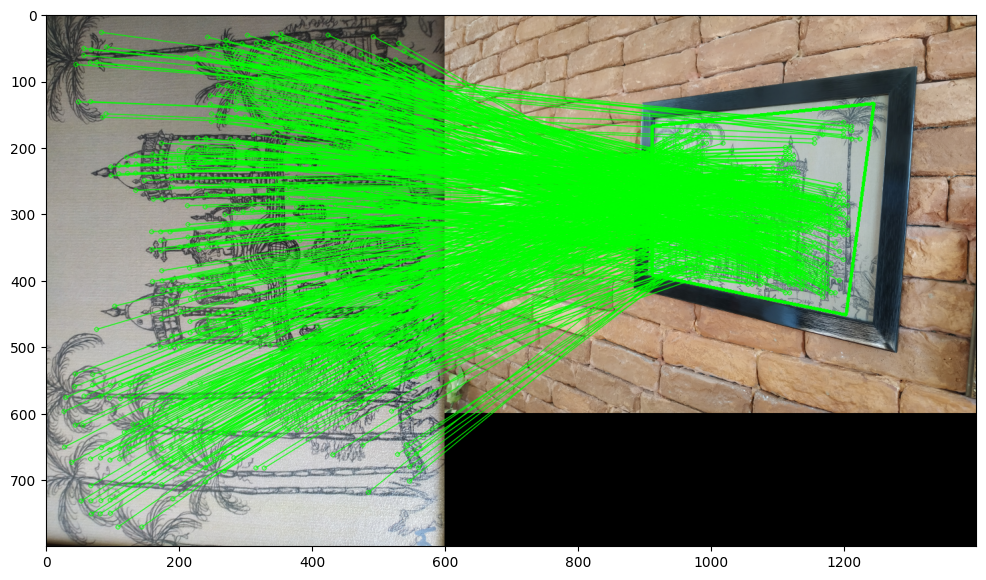

(<matplotlib.image.AxesImage at 0x7bd9cf9e6920>, None)

In [ ]:
# Now it works!
mkpts_0, mkpts_1, rot1to2 = match_xfeat_star_with_permutation_steerer(rot_im1, im2, top_k = 8000, min_cossim_coarse=.9)

print(f"Number 90 deg rotations from first image to second: {rot1to2}")

canvas = warp_corners_and_draw_matches(mkpts_0, mkpts_1, rot_im1, im2)
plt.figure(figsize=(12,12))
plt.imshow(canvas[..., ::-1]), plt.show()